Dataset Columns: Index(['sensitive_attribute', 'feature_1', 'feature_2', 'target'], dtype='object')


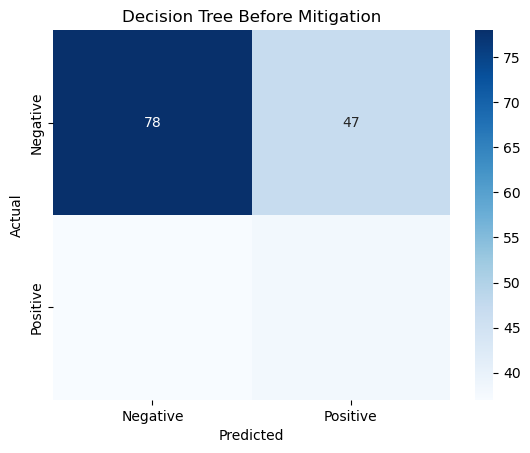

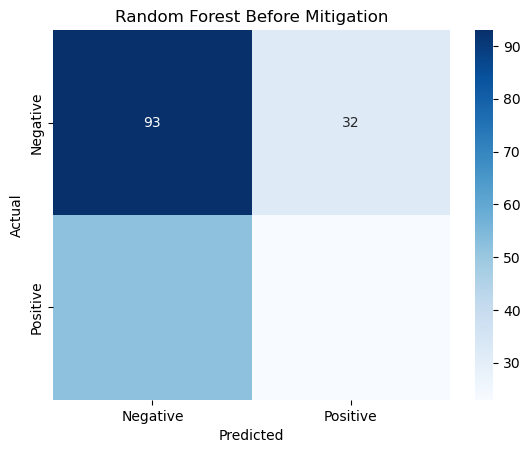

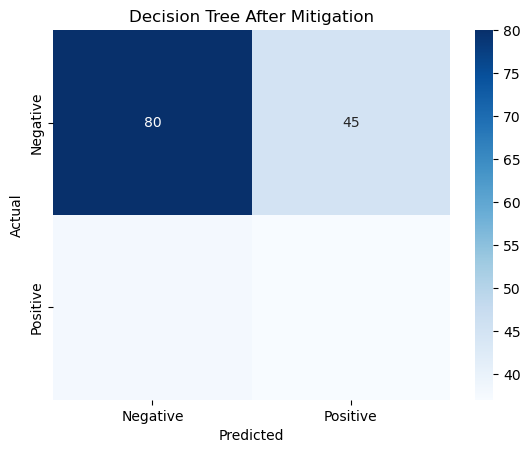

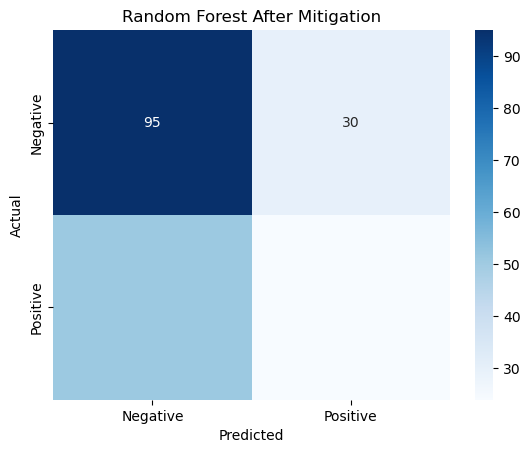

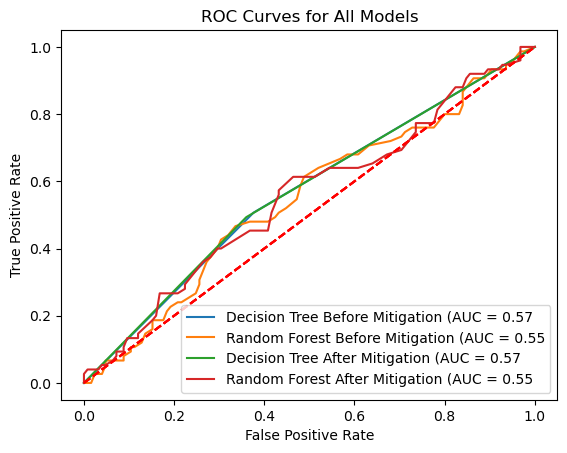

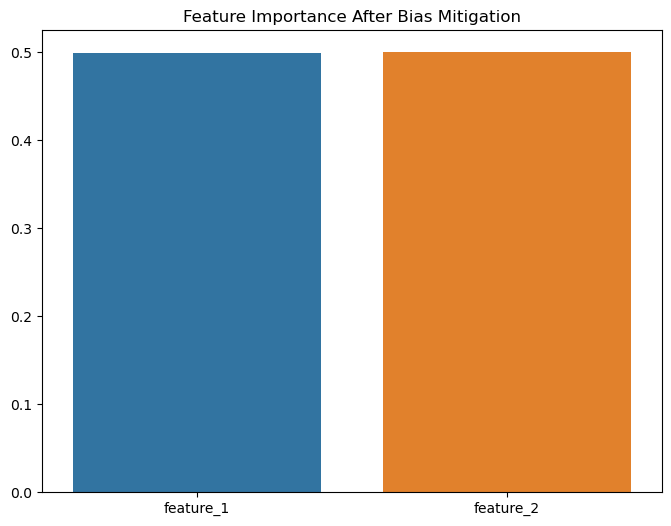


    Bias Identification and Mitigation Report
    
    **Before Bias Mitigation:**
    - Decision Tree:
                  precision    recall  f1-score   support

           0       0.68      0.62      0.65       125
           1       0.45      0.51      0.48        75

    accuracy                           0.58       200
   macro avg       0.56      0.57      0.56       200
weighted avg       0.59      0.58      0.58       200

    - Random Forest:
                  precision    recall  f1-score   support

           0       0.64      0.74      0.69       125
           1       0.42      0.31      0.35        75

    accuracy                           0.58       200
   macro avg       0.53      0.53      0.52       200
weighted avg       0.56      0.58      0.56       200

    
    **After Bias Mitigation:**
    - Decision Tree:
                  precision    recall  f1-score   support

           0       0.68      0.64      0.66       125
           1       0.45      0.49      0.4

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Load dataset
file_path = "sample_data.csv"
df = pd.read_csv(file_path)

# Display dataset columns to verify
print("Dataset Columns:", df.columns)

# Identify numerical features
df = df.select_dtypes(include=[np.number])  # Keep only numerical columns

# Ensure the dataset has required columns
if 'target' not in df.columns:
    raise KeyError("Dataset must contain a 'target' column for classification.")

# Select features and target variable
X = df.drop(columns=['target'])  # All numerical columns except target
y = df['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models before bias mitigation
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predictions before mitigation
dt_pred = dt.predict(X_test)
rf_pred = rf.predict(X_test)

# Manual Reweighting for Bias Mitigation
class_counts = y_train.value_counts()
sample_weights = y_train.map(lambda x: class_counts.max() / class_counts[x])

# Train models after bias mitigation
dt_rw = DecisionTreeClassifier(random_state=42)
dt_rw.fit(X_train, y_train, sample_weight=sample_weights)
rf_rw = RandomForestClassifier(random_state=42)
rf_rw.fit(X_train, y_train, sample_weight=sample_weights)

# Predictions after mitigation
dt_rw_pred = dt_rw.predict(X_test)
rf_rw_pred = rf_rw.predict(X_test)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(y_test, dt_pred, "Decision Tree Before Mitigation")
plot_confusion_matrix(y_test, rf_pred, "Random Forest Before Mitigation")
plot_confusion_matrix(y_test, dt_rw_pred, "Decision Tree After Mitigation")
plot_confusion_matrix(y_test, rf_rw_pred, "Random Forest After Mitigation")

# Function to plot ROC curves
def plot_roc_curve(y_true, y_pred_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{title} (AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

# Plot individual ROC Curves
plt.figure()
plot_roc_curve(y_test, dt.predict_proba(X_test)[:, 1], "Decision Tree Before Mitigation")
plot_roc_curve(y_test, rf.predict_proba(X_test)[:, 1], "Random Forest Before Mitigation")
plot_roc_curve(y_test, dt_rw.predict_proba(X_test)[:, 1], "Decision Tree After Mitigation")
plot_roc_curve(y_test, rf_rw.predict_proba(X_test)[:, 1], "Random Forest After Mitigation")
plt.title("ROC Curves for All Models")
plt.show()

# Feature Importance
plt.figure(figsize=(8, 6))
feature_importance = rf_rw.feature_importances_
sns.barplot(x=X.columns, y=feature_importance)
plt.title("Feature Importance After Bias Mitigation")
plt.show()

# Generate Report
def generate_report():
    report = """
    Bias Identification and Mitigation Report
    ========================================
    
    **Before Bias Mitigation:**
    - Decision Tree:
    {}
    - Random Forest:
    {}
    
    **After Bias Mitigation:**
    - Decision Tree:
    {}
    - Random Forest:
    {}
    """.format(
        classification_report(y_test, dt_pred),
        classification_report(y_test, rf_pred),
        classification_report(y_test, dt_rw_pred),
        classification_report(y_test, rf_rw_pred)
    )
    print(report)

# Print the report
generate_report()

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.figure_factory as ff
import plotly.graph_objects as go

# Load dataset
file_path = "sample_data.csv"
df = pd.read_csv(file_path)

# Data preprocessing
df = df.select_dtypes(include=[np.number])
if 'target' not in df.columns:
    raise KeyError("Dataset must contain a 'target' column for classification.")
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models before bias mitigation
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predictions before mitigation
dt_pred = dt.predict(X_test)
rf_pred = rf.predict(X_test)

# Manual Reweighting for Bias Mitigation
class_counts = y_train.value_counts()
sample_weights = y_train.map(lambda x: class_counts.max() / class_counts[x])

# Train models after bias mitigation
dt_rw = DecisionTreeClassifier(random_state=42)
dt_rw.fit(X_train, y_train, sample_weight=sample_weights)
rf_rw = RandomForestClassifier(random_state=42)
rf_rw.fit(X_train, y_train, sample_weight=sample_weights)

# Predictions after mitigation
dt_rw_pred = dt_rw.predict(X_test)
rf_rw_pred = rf_rw.predict(X_test)

# Initialize Dash app
app = dash.Dash(__name__)
app.layout = html.Div([
    html.H1("Bias Mitigation in AI Training Data"),
    dcc.Dropdown(
        id='model-dropdown',
        options=[
            {'label': 'Decision Tree Before Mitigation', 'value': 'dt_before'},
            {'label': 'Random Forest Before Mitigation', 'value': 'rf_before'},
            {'label': 'Decision Tree After Mitigation', 'value': 'dt_after'},
            {'label': 'Random Forest After Mitigation', 'value': 'rf_after'}
        ],
        value='dt_before'
    ),
    dcc.Graph(id='confusion-matrix'),
    dcc.Graph(id='roc-curve'),
    dcc.Graph(id='feature-importance')
])

@app.callback(
    Output('confusion-matrix', 'figure'),
    Output('roc-curve', 'figure'),
    Output('feature-importance', 'figure'),
    Input('model-dropdown', 'value')
)
def update_graph(selected_model):
    model_dict = {
        'dt_before': (dt_pred, dt, "Decision Tree Before Mitigation"),
        'rf_before': (rf_pred, rf, "Random Forest Before Mitigation"),
        'dt_after': (dt_rw_pred, dt_rw, "Decision Tree After Mitigation"),
        'rf_after': (rf_rw_pred, rf_rw, "Random Forest After Mitigation")
    }
    y_pred, model, title = model_dict[selected_model]
    cm = confusion_matrix(y_test, y_pred)
    cm_fig = ff.create_annotated_heatmap(z=cm, x=['Negative', 'Positive'], y=['Negative', 'Positive'], colorscale='Blues')
    cm_fig.update_layout(title=f"Confusion Matrix - {title}")
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_fig = go.Figure()
    roc_fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'AUC = {roc_auc:.2f}'))
    roc_fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash')))
    roc_fig.update_layout(title=f"ROC Curve - {title}", xaxis_title='False Positive Rate', yaxis_title='True Positive Rate')
    feature_imp_fig = go.Figure()
    feature_imp_fig.add_trace(go.Bar(x=X.columns, y=model.feature_importances_))
    feature_imp_fig.update_layout(title=f"Feature Importance - {title}", xaxis_title='Features', yaxis_title='Importance')
    return cm_fig, roc_fig, feature_imp_fig

if __name__ == '__main__':
    app.run_server(debug=True)


In [1]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import LabelEncoder

# Specify the path to your CSV file here
csv_file_path = "sample_data.csv"

def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

def detect_bias(df, target_column):
    bias_report = {}
    for col in df.select_dtypes(include=['object', 'category']).columns:
        if col != target_column:
            bias_report[col] = df[col].value_counts(normalize=True).to_dict()
    return bias_report

def mitigate_bias(df, target_column, sensitive_column):
    if sensitive_column in df.columns and target_column in df.columns:
        le = LabelEncoder()
        df[target_column] = le.fit_transform(df[target_column])
        df[sensitive_column] = le.fit_transform(df[sensitive_column])
        df = df.sample(frac=1).reset_index(drop=True)  # Shuffle data
    return df

df = load_data(csv_file_path)

app = dash.Dash(__name__)
app.layout = html.Div([
    html.H1("Bias Identification and Mitigation Dashboard"),
    dcc.Dropdown(
        id='target_column',
        options=[{'label': col, 'value': col} for col in df.columns],
        placeholder="Select Target Column"
    ),
    dcc.Dropdown(
        id='sensitive_column',
        options=[{'label': col, 'value': col} for col in df.columns],
        placeholder="Select Sensitive Column"
    ),
    html.Button('Detect Bias', id='detect_button', n_clicks=0),
    html.Button('Mitigate Bias', id='mitigate_button', n_clicks=0),
    html.Div(id='bias_output'),
    dash_table.DataTable(id='mitigated_data', page_size=5),
])

@app.callback(
    Output('bias_output', 'children'),
    Input('detect_button', 'n_clicks'),
    [Input('target_column', 'value')]
)
def update_bias_output(n_clicks, target_column):
    if n_clicks > 0 and target_column:
        bias_report = detect_bias(df, target_column)
        return html.Pre(str(bias_report))
    return ""

@app.callback(
    Output('mitigated_data', 'data'),
    Input('mitigate_button', 'n_clicks'),
    [Input('target_column', 'value'), Input('sensitive_column', 'value')]
)
def update_mitigated_data(n_clicks, target_column, sensitive_column):
    if n_clicks > 0 and target_column and sensitive_column:
        mitigated_df = mitigate_bias(df.copy(), target_column, sensitive_column)
        return mitigated_df.to_dict('records')
    return []

if __name__ == '__main__':
    app.run_server(debug=True)


C:\Users\Harsh\AppData\Local\Temp\ipykernel_4644\2533402110.py:2: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
C:\Users\Harsh\AppData\Local\Temp\ipykernel_4644\2533402110.py:3: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
C:\Users\Harsh\AppData\Local\Temp\ipykernel_4644\2533402110.py:4: UserWarning: 
The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`
  import dash_table
